In [182]:
import seaborn as sns
# ^^^ pyforest auto-imports - don't write above this line
# Library imports
import pyforest
import struct
import skimage.transform
import tensorflow as tf
import datetime

# Dependency imports
from tensorflow.keras import datasets, layers, models
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from PIL import Image
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder

# Notebook Extentions
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [88]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


# Japanese Handwriting Recognition Project

![Japanese_Kana_Chart](img/variant-hentaigana-chart.jpg)

## Agenda

This project aims to accurately predict Japanese handwriting and display the corresponding text output correctly. Using the three main Japanese language writing systems (Kanji, Hiragana, Katakana), the data is from the [ETL Character Database](http://etlcdb.db.aist.go.jp/), which includes over a million of Japanese characters hand-written and reorganized by the [National Institute of Advanced Industrial Science and Technology (AIST)](http://www.jeita.or.jp/english/). 

## Data Information

- Each file contains 5 data sets except ETL8G_33
- Each data set contains 956 characters written by a writer.
- Each writer wrote 10 sheets (genkouyoushi) per data set

### Japanese Character Dataset Info

- **Hiragana (ETL 8)**
    - 71 hiragana characters (46 unique + 29 diphthongs)
    - 160 writers
    - 8199 records (genkouyoushi sheets) 
    - 1,254,120,000 unique handwritten hiragana characters (shared with kanji chars in the same files)
- **Kanji (ETL 8)**
    - 883 daily use kanji
    - 160 writers
    - 8199 records 
    - 152,878,411 unique handwritten kanji (shared with hiragana chars in the same files)
- **Katakana (ETL 1)**
    - 46 katakana characters (46 unique, dipthongs not included as they are phonetically identical to hiragana)
    - 1411 writers
    - 2052 records
    - 2,436,366 unique handwritten katakana characters

### Import & Read Hiragana

In [2]:
hira_kanji_record = 8199

In [3]:
# Reading the Hiragana ETL8G File
def read_ETL8G(f):
    s = f.read(hira_kanji_record)
    r = struct.unpack('>2H8sI4B4H2B30x8128s11x', s)
    iF = Image.frombytes('F', (128, 127), r[14], 'bit', 4)
    iL = iF.convert('L')
    return r + (iL,)

In [4]:
# Function to read the binary code present in each of the 33 files included in the ETL8G folder
def read_hiragana():
    # Characters = 71, writers = 160, y = 127, x = 128
    hiragana = np.zeros([71, 160, 127, 128], dtype = np.uint8)

    for j in range(1, 33):
        filename = 'data/ETL8G/ETL8G_{:02d}'.format(j)
        with open(filename, 'rb') as f:
            for id_dataset in range(5):
                moji = 0
                for i in range(956):
                    r = read_ETL8G(f)
                    if b'.HIRA' in r[2] or b'.WO.' in r[2]:
                        if not b'KAI' in r[2] and not b'HEI' in r[2]:
                            hiragana[moji, (j - 1) * 5 + id_dataset] = np.array(r[-1])
                            moji += 1
    np.savez_compressed('data/hiragana.npz', hiragana)

In [5]:
# Running the Function Above
# read_hiragana()

In [6]:
hiragana_data = np.load('data/hiragana.npz')
hira_test = hiragana_data.f.arr_0

In [7]:
hira_test.shape

(71, 160, 127, 128)

### Import & Read Kanji

In [8]:
def read_kanji():
    # Characters = 883, writers = 160, y = 127, x = 128
    kanji = np.zeros([883, 160, 127, 128], dtype=np.uint8)
    for i in range(1, 33):
        filename = 'data/ETL8G/ETL8G_{:02d}'.format(i)
        with open(filename, 'rb') as f:
            for dataset in range(5):
                char = 0
                for j in range(956):
                    r = read_ETL8G(f)
                    if not (b'.HIRA' in r[2] or b'.WO.' in r[2]): 
                        kanji[char, (i - 1) * 5 + dataset] = np.array(r[-1])
                        char += 1
    np.savez_compressed('data/kanji.npz', kanji)

In [ ]:
# read_kanji()

In [9]:
kanji_data = np.load('data/kanji.npz')
kanji_test = kanji_data.f.arr_0

In [10]:
kanji_test.shape

(883, 160, 127, 128)

### Import & Read Katakana

In [11]:
kana_record = 2052

In [12]:
# Reading in the Katakana ETL1 File
def read_ETL1(total_sheets, f):
    s = f.read(kana_record)
    r = struct.unpack('>H2sH6BI4H4B4x2016s4x', s)
    iF = Image.frombytes('F', (64, 63), r[18], 'bit', 4)
    iL = iF.convert('L')
    return r + (iL,)

In [13]:
def read_katakana():
    # Character type = 46, writers = 1411, y = 63, x = 64
    katakana = np.zeros([46, 1411, 63, 64], dtype=np.uint8)
    counter = 0
    moji = 0
    for k in range(7, 14):
        filename = 'data/ETL1/ETL1C_{:02d}'.format(k)
        with open(filename, 'rb') as f:
            total_sheets = 0
            categories = 8
            if k == 13:
                categories = 3
            for j in range(categories):
                incrimenter = 0
                person = 0
                sheets = 1411
                if k == 9 and j == 4:
                    sheets = 1410
                elif k == 12 and j == 1:
                    sheets = 1410
                for i in range(sheets):
                    r = read_ETL1(total_sheets, f)
                    total_sheets += sheets
                    if k < 11 or (k >= 11 and b' I' not in r[1] and b' E' not in r[1] and b'WI' not in r[1] and b' U' not in r[1] and b'WE' not in r[1]):
                        pixels = np.array(r[-1])
                        for row in pixels:
                            for i in range(len(row)):
                                if row[i] == 1 or row[i] == 2:
                                    row[i] = 0
                        katakana[moji, person] = pixels
                        incrimenter = 1
                        person += 1
                moji += incrimenter
    np.savez_compressed('data/katakana.npz', katakana)

In [14]:
# read_katakana()

In [15]:
katakana_data = np.load('data/katakana.npz')
kana_test = katakana_data.f.arr_0

In [16]:
kana_test.shape

(46, 1411, 63, 64)

## Visualizing Characters

### Visualizing Hiragana

In [17]:
# Visualizing Hiragana
def visualize_hiragana():
    for j in range(1, 2):
        filename = 'data/ETL8G/ETL8G_{:02d}'.format(j)
        with open(filename, 'rb') as f:
            for id_dataset in range(1):
                new_img = Image.new('L', (128*32, 128*30))
                for i in range(956):
                    r = read_ETL8G(f)
                    if b'.HIRA' in r[2]:
                        print(r[:4])

In [18]:
visualize_hiragana()

(1, 9250, b'A.HIRA  ', 1)
(1, 9252, b'I.HIRA  ', 16)
(1, 9254, b'U.HIRA  ', 31)
(1, 9256, b'E.HIRA  ', 46)
(1, 9258, b'O.HIRA  ', 61)
(1, 9259, b'KA.HIRA ', 76)
(1, 19007, b'HEI.HIRA', 83)
(1, 9260, b'GA.HIRA ', 91)
(2, 9261, b'KI.HIRA ', 1)
(2, 9262, b'GI.HIRA ', 16)
(2, 9263, b'KU.HIRA ', 31)
(2, 9264, b'GU.HIRA ', 46)
(2, 9265, b'KE.HIRA ', 61)
(2, 9266, b'GE.HIRA ', 76)
(2, 9267, b'KO.HIRA ', 91)
(3, 9268, b'GO.HIRA ', 193)
(3, 9269, b'SA.HIRA ', 208)
(3, 9270, b'ZA.HIRA ', 223)
(3, 9271, b'SHI.HIRA', 238)
(3, 9272, b'JI.HIRA ', 253)
(3, 9273, b'SU.HIRA ', 268)
(3, 9274, b'ZU.HIRA ', 283)
(4, 9275, b'SE.HIRA ', 289)
(4, 9276, b'ZE.HIRA ', 304)
(4, 9277, b'SO.HIRA ', 319)
(4, 9278, b'ZO.HIRA ', 334)
(4, 9279, b'TA.HIRA ', 349)
(4, 9280, b'DA.HIRA ', 364)
(4, 9281, b'CHI.HIRA', 378)
(5, 9282, b'JI.HIRA ', 385)
(5, 9284, b'TSU.HIRA', 400)
(5, 9285, b'ZU.HIRA ', 415)
(5, 9286, b'TE.HIRA ', 430)
(5, 9287, b'DE.HIRA ', 445)
(5, 9288, b'TO.HIRA ', 460)
(5, 9289, b'DO.HIRA ', 475)
(6, 9290

In [19]:
def one_kana():
    filename = 'data/ETL8G/ETL8G_01'
    counter = 0
    with open(filename, 'rb') as f:
        for id_dataset in range(5):
            for i in range(956):
                r = read_ETL8G(f)
                if b'.WO.' in r[2]:
                    iE = Image.eval(r[-1], lambda x: 255-x*16)
                    fn = 'kana_visualization.png'.format((r[0]-1)%20+1, hex(r[1])[-4:])
                    # iE.save(fn, 'PNG')

In [20]:
one_kana()

- Kana Sample Visualization ![kana](img/kana_visualization.png)

### Visualizing Kanji

In [ ]:
def visualize_kanji():
    for j in range(1, 2):
        filename = 'data/ETL8G/ETL8G_{:02d}'.format(j)
        with open(filename, 'rb') as f:
            for id_dataset in range(1):
                new_img = Image.new('L', (128*32, 128*30))
                for i in range(956):
                    r = read_ETL8G(f)
                    if not (b'.HIRA' in r[2] or b'.WO.' in r[2]):
                        print(r[:4])

In [ ]:
visualize_kanji()

In [21]:
def one_kanji():
    filename = 'data/ETL8G/ETL8G_01'
    counter = 0
    with open(filename, 'rb') as f:
        for id_dataset in range(5):
            for i in range(956):
                r = read_ETL8G(f)
                if not (b'.HIRA' in r[2] or b'.WO.' in r[2]):
                    iE = Image.eval(r[-1], lambda x: 255-x*16)
                    fn = 'kanji_visualization.png'.format((r[0]-1)%20+1, hex(r[1])[-4:])
                    # iE.save(fn, 'PNG')

In [22]:
one_kanji()

- Kanji Sample Visualization: ![kanji](img/kanji_visualization.png)

## Feature Engineering

- The image dimensions need to be resized for the ML model to work on them. Resizing to 64x64 is an option, but for processing speed and time they will instead be resized to 32x32 pixels.

### Resizing Hiragana Images

In [23]:
# 71 unique classes of hiragana (including dipthongs)
hiragana_class = 71

# Image dimensions
img_row, img_col = 48, 48

In [24]:
hiragana_table = np.load('data/hiragana.npz')['arr_0'].reshape([-1, 127, 128]).astype(np.float32)
hiragana_table = hiragana_table/np.max(hiragana_table)

In [25]:
hiragana_train = np.zeros([hiragana_class * 160, img_row, img_col], dtype = np.float32)

for i in range(hiragana_class * 160):
    hiragana_train[i] = skimage.transform.resize(hiragana_table[i], (img_row, img_col))

### Resizing Kanji Images

In [26]:
# 879 unique classes of kanji (most daily used kanji)
kanji_class = 873

In [150]:
kanji_table = np.load('data/kanji.npz')['arr_0'].reshape([-1, 127, 128]).astype(np.float32)
kanji_table = kanji_table/np.max(kanji_table)

- The kanji and hiragana characters share the ECT8 dataset, and they are not intuitively arranged. This accounts for this so hiragana are not mistakenly classified as kanji characters.

In [151]:
kanji_train = np.zeros([kanji_class * 160, img_row, img_col], dtype = np.float32)

for i in range((kanji_class + 4) * 160):
    if int(i / 160) != 88 and int( i / 160) != 219 and int( i / 160) != 349 and int( i / 160) != 457:
        if int(i / 160) < 88:
            kanji_train[i] = skimage.transform.resize(kanji_table[i], (img_row, img_col))
        if int(i/160) > 88 and int(i/160) < 219:
            kanji_train[i-160] = skimage.transform.resize(kanji_table[i], (img_row, img_col))
        if int(i/160) > 219 and int(i/160) < 349:
            kanji_train[i-320] = skimage.transform.resize(kanji_table[i], (img_row, img_col))
        if int(i/160) > 349 and int(i/160) < 457:
            if int(i/160) > 457:
                kanji_train[i-640] = skimage.transform.resize(kanji_table[i], (img_row, img_col))

### Resizing Katakana Images

In [29]:
# 71 frequently used katakana characters (including dipthongs)
katakana_class = 46

In [30]:
katakana_table = np.load('data/katakana.npz')['arr_0'].reshape([-1, 63, 64]).astype(np.float32)
katakana_table = katakana_table/np.max(katakana_table)

In [31]:
katakana_train = np.zeros([katakana_class * 1411, img_row, img_col], dtype = np.float32)

for i in range(katakana_class * 1411):
    katakana_train[i] = skimage.transform.resize(katakana_table[i], (img_row, img_col))

## Model Preparation

### Creating Labels

In [32]:
y_labels_hiragana = np.repeat(np.arange(hiragana_class), 160)
y_labels_kanji = np.repeat(np.arange(kanji_class), 160)
y_labels_katakana = np.repeat(np.arange(katakana_class), 1411)

### Train-Test Split

#### Hiragana Train-Test Split

In [33]:
hiragana_train, hiragana_test, hiragana_labels, hiragana_test_labels = train_test_split(
                                                    hiragana_train,
                                                    y_labels_hiragana,
                                                    random_state=42,
                                                    test_size=0.2)

#### Kanji Train-Test Split

In [152]:
kanji_train, kanji_test, kanji_labels, kanji_test_labels = train_test_split(
                                                    kanji_train,
                                                    y_labels_kanji,
                                                    random_state=42,
                                                    test_size=0.3)

#### Katakana Train-Test Split

In [35]:
katakana_train, katakana_test, katakana_labels, katakana_test_labels = train_test_split(
                                                    katakana_train,
                                                    y_labels_katakana,
                                                    random_state=42,
                                                    test_size=0.2)

### Multiclass Classification

- For classification of multiple input types and target variables, we need to create a cross-validation set as well as OneHotEncode our y values (y_train, y_test, y_val)

#### Hiragana Multiclass Preparation

In [37]:
# Labels are our y values
hira_X_train, hira_X_val, hira_y_train, hira_y_val =\
    train_test_split(hiragana_train, hiragana_labels, random_state = 42, test_size = 0.2)

hira_X_train, hira_X_val, hira_X_test = hira_X_train/np.max(hira_X_train), hira_X_val/np.max(hira_X_val),\
                                        hiragana_test/np.max(hiragana_test)

In [38]:
hira_X_val.shape

(1818, 48, 48)

In [39]:
hiragana_ohe = OneHotEncoder(sparse = False, handle_unknown = 'ignore')
hira_y_train = hiragana_ohe.fit_transform(hira_y_train.reshape(-1, 1))
hira_y_val = hiragana_ohe.transform(hira_y_val.reshape(-1, 1))
hira_y_test = hiragana_ohe.transform(hiragana_test_labels.reshape(-1, 1))

#### Kanji Multiclass Preparation

In [153]:
# Labels are our y values
kanji_X_train, kanji_X_val, kanji_y_train, kanji_y_val =\
    train_test_split(kanji_train, kanji_labels, random_state = 42, test_size = 0.3)

kanji_X_train, kanji_X_val, kanji_X_test = kanji_X_train/np.max(kanji_X_train), kanji_X_val/np.max(kanji_X_val),\
                                           kanji_test/np.max(kanji_test)

In [154]:
kanji_ohe = OneHotEncoder(sparse = False, handle_unknown = 'ignore')
kanji_y_train = kanji_ohe.fit_transform(kanji_y_train.reshape(-1, 1))
kanji_y_val = kanji_ohe.transform(kanji_y_val.reshape(-1, 1))
kanji_y_test = kanji_ohe.transform(kanji_test_labels.reshape(-1, 1))

#### Katakana Multiclass Preparation

In [43]:
# Labels are our y values
katakana_X_train, katakana_X_val, katakana_y_train, katakana_y_val =\
    train_test_split(katakana_train, katakana_labels, random_state = 42, test_size = 0.2)

katakana_X_train, katakana_X_val, katakana_X_test = katakana_X_train/np.max(katakana_X_train),\
                                                katakana_X_val/np.max(katakana_X_val), katakana_test/np.max(katakana_test)

In [44]:
katakana_ohe = OneHotEncoder(sparse = False, handle_unknown = 'ignore')
katakana_y_train = katakana_ohe.fit_transform(katakana_y_train.reshape(-1, 1))
katakana_y_val = katakana_ohe.transform(katakana_y_val.reshape(-1, 1))
katakana_y_test = katakana_ohe.transform(katakana_test_labels.reshape(-1, 1))

### Adding Variation with ImageDataGenerator

- Tensorflow's ImageDataGenerator can augment images to create new vesions of the data, essentially artificially inserting variation into the data
- Images can be rotated, zoomed, and flipped
- This variation is used to avoid overfitting on the training set
- Following augmentation is for a 2D CNN

#### Hiragana Augmentation

In [45]:
if K.image_data_format() == 'channels_first':
    hira_X_train = hira_X_train.reshape(hira_X_train.shape[0], 1, img_row, img_col)
    hira_X_test = hira_X_test.reshape(hira_X_test.shape[0], 1, img_row, img_col)
    hira_X_val = hira_X_val.reshape(hira_X_val.shape[0], 1, img_row, img_col)
    hira_shape = (1, img_row, img_col) 
else:
    hira_X_train = hira_X_train.reshape(hira_X_train.shape[0], img_row, img_col, 1)
    hira_X_test = hira_X_test.reshape(hira_X_test.shape[0], img_row, img_col, 1)
    hira_X_val = hira_X_val.reshape(hira_X_val.shape[0], img_row, img_col, 1)
    hira_shape = (img_row, img_col, 1) # For CNN

hiragana_datagen = ImageDataGenerator(rotation_range = 15, zoom_range = 0.2)

hiragana_datagen.fit(hira_X_train)

In [98]:
hira_X_train.shape

(7270, 48, 48, 1)

In [99]:
hira_X_val.shape

(1818, 48, 48, 1)

#### Kanji Augmentation

In [155]:
if K.image_data_format() == 'channels_first':
    kanji_X_train = kanji_X_train.reshape(kanji_X_train.shape[0], 1, img_row, img_col)
    kanji_X_test = kanji_X_test.reshape(kanji_X_test.shape[0], 1, img_row, img_col)
    kanji_X_val = kanji_X_val.reshape(kanji_X_val.shape[0], 1, img_row, img_col)
    kanji_shape = (1, img_row, img_col) 
else:
    kanji_X_train = kanji_X_train.reshape(kanji_X_train.shape[0], img_row, img_col, 1)
    kanji_X_test = kanji_X_test.reshape(kanji_X_test.shape[0], img_row, img_col, 1)
    kanji_X_val = kanji_X_val.reshape(kanji_X_val.shape[0], img_row, img_col, 1)
    kanji_shape = (img_row, img_col, 1) # For CNN

kanji_datagen = ImageDataGenerator(rotation_range = 15, zoom_range = 0.2)

kanji_datagen.fit(kanji_X_train)

In [156]:
kanji_X_train.shape

(68443, 48, 48, 1)

In [157]:
kanji_X_val.shape

(29333, 48, 48, 1)

#### Katakana Augmentation

In [51]:
if K.image_data_format() == 'channels_first':
    katakana_X_train = katakana_X_train.reshape(katakana_X_train.shape[0], 1, img_row, img_col)
    katakana_X_test = katakana_X_test.reshape(katakana_X_test.shape[0], 1, img_row, img_col)
    katakana_X_val = katakana_X_val.reshape(katakana_X_val.shape[0], 1, img_row, img_col)
    katakana_shape = (1, img_row, img_col) 
else:
    katakana_X_train = katakana_X_train.reshape(katakana_X_train.shape[0], img_row, img_col, 1)
    katakana_X_test = katakana_X_test.reshape(katakana_X_test.shape[0], img_row, img_col, 1)
    katakana_X_val = katakana_X_val.reshape(katakana_X_val.shape[0], img_row, img_col, 1)
    katakana_shape = (img_row, img_col, 1) # For CNN

katakana_datagen = ImageDataGenerator(rotation_range = 15, zoom_range = 0.2)

katakana_datagen.fit(katakana_X_train)

In [100]:
katakana_X_train.shape

(41539, 48, 48, 1)

In [101]:
katakana_X_val.shape

(10385, 48, 48, 1)

## Final Visualization Tables

- Checking that our finalized data was extracted and correctly, and is readable in the correct visual format.

### Hiragana Table

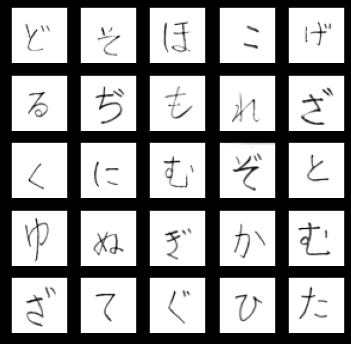

In [54]:
plt.figure(figsize = (6, 6)).patch.set_facecolor('black')
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(hira_X_train[i], cmap = plt.cm.binary)
plt.show();

### Kanji Table

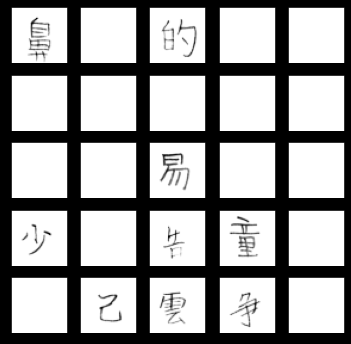

In [158]:
plt.figure(figsize = (6, 6)).patch.set_facecolor('black')
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(kanji_X_train[i], cmap = plt.cm.binary)
plt.show();

### Katakana Table

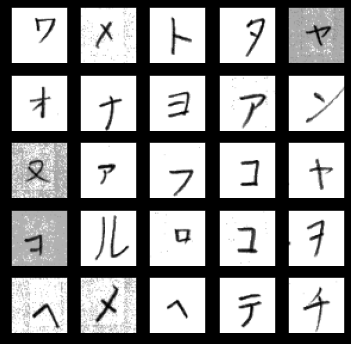

In [56]:
plt.figure(figsize = (6, 6)).patch.set_facecolor('black')
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(katakana_X_train[i], cmap = plt.cm.binary)
plt.show();

## Modeling

### Hiragana CNN

#### Hiragana CNN Prep

In [61]:
hira_model = models.Sequential()

hira_model.add(layers.Conv2D(32, (3, 3), padding = 'same', input_shape = hira_shape, data_format = 'channels_last'))
hira_model.add(Activation('relu'))
hira_model.add(layers.Conv2D(32, (3, 3), padding = 'same'))
hira_model.add(Activation('relu'))
hira_model.add(layers.MaxPooling2D((2, 2)))
hira_model.add(Dropout(0.2))

hira_model.add(layers.Conv2D(64, (3, 3), padding = 'same'))
hira_model.add(Activation('relu'))
hira_model.add(layers.Conv2D(128, (3, 3), padding = 'same'))
hira_model.add(Activation('relu'))
hira_model.add(layers.MaxPooling2D((2, 2)))
hira_model.add(Dropout(0.2))

hira_model.add(Flatten())
hira_model.add(Dense(256))
hira_model.add(Activation('relu'))
hira_model.add(Dropout(0.2))
hira_model.add(Dense(hiragana_class))
hira_model.add(Activation('softmax'))

In [62]:
hira_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 24, 24, 64)       

In [86]:
hira_es = EarlyStopping(patience = 8, verbose = 1, restore_best_weights = True)
hira_lr = ReduceLROnPlateau(factor = 0.5, patience = 3, verbose = 1)

In [65]:
hira_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

hiragana_results = hira_model.fit(hiragana_datagen.flow(hira_X_train, hira_y_train, batch_size = 32),
          epochs = 30, callbacks = (hira_es, hira_lr), validation_data = (hira_X_val, hira_y_val))

Epoch 1/30
228/228 [==============================] - 32s 140ms/step - loss: 2.4548 - accuracy: 0.3680 - val_loss: 0.7730 - val_accuracy: 0.7657
Epoch 2/30
228/228 [==============================] - 31s 138ms/step - loss: 0.9538 - accuracy: 0.7124 - val_loss: 0.3851 - val_accuracy: 0.8724
Epoch 3/30
228/228 [==============================] - 32s 139ms/step - loss: 0.5514 - accuracy: 0.8267 - val_loss: 0.2251 - val_accuracy: 0.9323
Epoch 4/30
228/228 [==============================] - 32s 141ms/step - loss: 0.4044 - accuracy: 0.8754 - val_loss: 0.1414 - val_accuracy: 0.9571
Epoch 5/30
228/228 [==============================] - 32s 138ms/step - loss: 0.3051 - accuracy: 0.9052 - val_loss: 0.1502 - val_accuracy: 0.9543
Epoch 6/30
228/228 [==============================] - 32s 140ms/step - loss: 0.2401 - accuracy: 0.9261 - val_loss: 0.1687 - val_accuracy: 0.9499
Epoch 7/30
228/228 [==============================] - 32s 142ms/step - loss: 0.2229 - accuracy: 0.9254 - val_loss: 0.0971 - val_ac

#### Hiragana CNN Model Evaluation

In [66]:
hira_history = hiragana_results.history
hira_training_loss = hira_history['loss']
hira_val_loss = hira_history['val_loss']
hira_training_accuracy = hira_history['accuracy']
hira_val_accuracy = hira_history['val_accuracy']

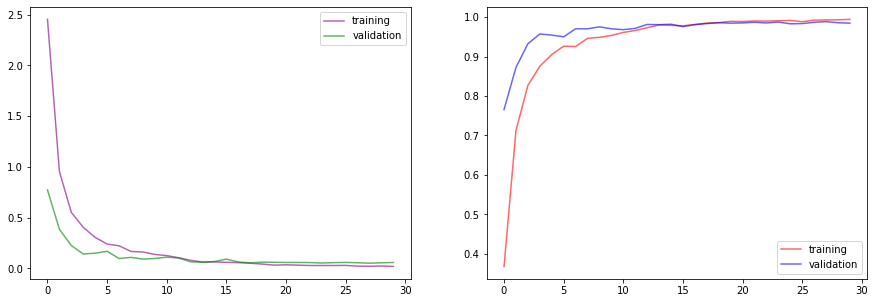

In [133]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))


sns.lineplot(x = list(range(len(hira_training_loss))),
             y = hira_training_loss, color = 'purple', alpha = 0.6, label='training', ax = ax1)
sns.lineplot(x = list(range(len(hira_val_loss))),
             y = hira_val_loss, color = 'green', alpha = 0.6, label = 'validation', ax = ax1)
sns.lineplot(x = list(range(len(hira_training_loss))),
             y = hira_training_accuracy, color='r', alpha = 0.6, label='training',ax = ax2)
sns.lineplot(x = list(range(len(hira_val_loss))),
             y = hira_val_accuracy, color = 'b', alpha = 0.6, label = 'validation',ax = ax2)
# plt.savefig('img/hiragana_loss_acc')
ax1.legend();

#### Hiragana Test Data Results

In [78]:
hira_y_hat_test = np.argmax(hira_model.predict(hira_X_test), axis=-1)
hira_test_restore = hiragana_ohe.inverse_transform(hira_y_test)
confusion_matrix(hira_test_restore, hira_y_hat_test)

array([[37,  0,  0, ...,  0,  0,  0],
       [ 0, 31,  0, ...,  0,  0,  0],
       [ 0,  0, 36, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 37,  0,  0],
       [ 0,  0,  0, ...,  0, 34,  0],
       [ 0,  0,  0, ...,  0,  0, 40]], dtype=int64)

In [122]:
hira_test_loss, hira_test_acc = hira_model.evaluate(hira_X_test, hira_y_test)

71/71 [==============================] - 2s 29ms/step - loss: 0.0457 - accuracy: 0.9859


In [123]:
print(f'We acheived a test accuracy of {round(hira_test_acc, 4)}% on our Hiragana dataset.')

We acheived a test accuracy of 0.9859% on our Hiragana dataset.


### Kanji CNN

#### Kanji CNN Prep

In [177]:
kanji_model = models.Sequential()

kanji_model.add(layers.Conv2D(64, (3, 3), activation = 'relu', padding = 'same', input_shape = kanji_shape, data_format = 'channels_last'))
kanji_model.add(layers.MaxPooling2D((2, 2)))
kanji_model.add(layers.Conv2D(64, (3, 3), activation = 'relu', padding = 'same'))
kanji_model.add(layers.MaxPooling2D((2, 2)))
kanji_model.add(layers.Flatten())
kanji_model.add(Dropout(0.5))
kanji_model.add(layers.Dense(2048, activation = 'relu'))
kanji_model.add(layers.Dense(kanji_class, activation = 'softmax'))

In [178]:
kanji_model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 48, 48, 64)        640       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 9216)              0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 9216)              0         
_________________________________________________________________
dense_23 (Dense)             (None, 2048)            

In [183]:
# Callbacks
kanji_es = EarlyStopping(patience = 2, verbose = 1, restore_best_weights = True)
kanji_lr = ReduceLROnPlateau(factor = 0.5, patience = 3, verbose = 1)

# Tensorboard Callback
log_dir = 'logs/' + datetime.datetime.now().strftime('Y%m%d-%H%M%S')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 1)

In [164]:
kanji_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

kanji_results = kanji_model.fit(kanji_datagen.flow(kanji_X_train, kanji_y_train, shuffle = True),
          epochs = 50, callbacks = (kanji_es, kanji_lr, tensorboard_callback), validation_data = (kanji_X_val, kanji_y_val))

Epoch 1/25
   1/2139 [..............................] - ETA: 0s - loss: 6.7690 - accuracy: 0.0000e+00WARNING:tensorflow:From C:\Users\User\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
2139/2139 [==============================] - 243s 114ms/step - loss: 5.7390 - accuracy: 0.0401 - val_loss: 4.3312 - val_accuracy: 0.2677
Epoch 2/25
2139/2139 [==============================] - 242s 113ms/step - loss: 4.7168 - accuracy: 0.1707 - val_loss: 3.9771 - val_accuracy: 0.3460
Epoch 3/25
2139/2139 [==============================] - 240s 112ms/step - loss: 4.4141 - accuracy: 0.2357 - val_loss: 3.9077 - val_accuracy: 0.3620
Epoch 4/25
2139/2139 [==============================] - 240s 112ms/step - loss: 4.2807 - accuracy: 0.2666 - val_loss: 3.8699 - val_accuracy: 0.3749
Epoch 5/25
2139/2139 [===============

#### Kanji CNN Model Evaluation

In [ ]:
kanji_history = kanji_results.history
kanji_training_loss = kanji_history['loss']
kanji_val_loss = kanji_history['val_loss']
kanji_training_accuracy = kanji_history['accuracy']
kanji_val_accuracy = kanji_history['val_accuracy']

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))


sns.lineplot(x = list(range(len(kanji_training_loss))),
             y = kanji_training_loss, color = 'r', label='training', ax = ax1)
sns.lineplot(x = list(range(len(kanji_val_loss))),
             y = kanji_val_loss, color = 'b', label = 'validation', ax = ax1)
sns.lineplot(x = list(range(len(kanji_training_loss))),
             y = kanji_training_accuracy, color='r', label='training',ax = ax2)
sns.lineplot(x = list(range(len(kanji_val_loss))),
             y = kanji_val_accuracy, color = 'b', label = 'validation',ax = ax2)
ax1.legend();

#### Kanji Test Data Results

In [78]:
kanji_y_hat_test = np.argmax(kanji_model.predict(kanji_X_test), axis=-1)
kanji_test_restore = kanji_ohe.inverse_transform(kanji_y_test)
confusion_matrix(kanji_test_restore, kanji_y_hat_test)

array([[37,  0,  0, ...,  0,  0,  0],
       [ 0, 31,  0, ...,  0,  0,  0],
       [ 0,  0, 36, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 37,  0,  0],
       [ 0,  0,  0, ...,  0, 34,  0],
       [ 0,  0,  0, ...,  0,  0, 40]], dtype=int64)

In [69]:
kanji_test_loss, kanji_test_acc = kanji_model.evaluate(kanji_X_test, kanji_y_test)

71/71 [==============================] - 2s 29ms/step - loss: 0.0457 - accuracy: 0.9859


In [120]:
print(f'We acheived a test accuracy of {round(kanji_test_acc, 4)}% on our Kanji dataset.')

NameError: name 'kanji_test_acc' is not defined

### Katakana CNN

#### Katakana CNN Prep

In [108]:
katakana_model = models.Sequential()

katakana_model.add(layers.Conv2D(32, (3, 3), padding = 'same', input_shape = katakana_shape, data_format = 'channels_last'))
katakana_model.add(Activation('relu'))
katakana_model.add(layers.Conv2D(32, (3, 3), padding = 'same'))
katakana_model.add(Activation('relu'))
katakana_model.add(layers.MaxPooling2D((2, 2)))
katakana_model.add(Dropout(0.2))

katakana_model.add(layers.Conv2D(64, (3, 3), padding = 'same'))
katakana_model.add(Activation('relu'))
katakana_model.add(layers.Conv2D(64, (3, 3), padding = 'same'))
katakana_model.add(Activation('relu'))
katakana_model.add(layers.MaxPooling2D((2, 2)))
katakana_model.add(Dropout(0.2))

katakana_model.add(Flatten())
katakana_model.add(Dense(256))
katakana_model.add(Activation('relu'))
katakana_model.add(Dropout(0.2))
katakana_model.add(Dense(katakana_class))
katakana_model.add(Activation('softmax'))

In [109]:
katakana_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 48, 48, 32)        320       
_________________________________________________________________
activation_22 (Activation)   (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 48, 48, 32)        9248      
_________________________________________________________________
activation_23 (Activation)   (None, 48, 48, 32)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 24, 24, 64)       

In [112]:
katakana_es = EarlyStopping(patience = 8, verbose = 1, restore_best_weights = True)
katakana_lr = ReduceLROnPlateau(factor = 0.5, patience = 3, verbose = 1)

In [111]:
katakana_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

katakana_results = katakana_model.fit(katakana_datagen.flow(katakana_X_train, katakana_y_train, batch_size = 32),
          epochs = 30, callbacks = (katakana_es, katakana_lr), validation_data = (katakana_X_val, katakana_y_val))

Epoch 1/30
1299/1299 [==============================] - 152s 117ms/step - loss: 0.9373 - accuracy: 0.7370 - val_loss: 0.1801 - val_accuracy: 0.9542
Epoch 2/30
1299/1299 [==============================] - 154s 119ms/step - loss: 0.2966 - accuracy: 0.9163 - val_loss: 0.1197 - val_accuracy: 0.9720
Epoch 3/30
1299/1299 [==============================] - 151s 116ms/step - loss: 0.2108 - accuracy: 0.9408 - val_loss: 0.0967 - val_accuracy: 0.9786
Epoch 4/30
1299/1299 [==============================] - 152s 117ms/step - loss: 0.1737 - accuracy: 0.9526 - val_loss: 0.1078 - val_accuracy: 0.9773
Epoch 5/30
1299/1299 [==============================] - 151s 116ms/step - loss: 0.1507 - accuracy: 0.9581 - val_loss: 0.0849 - val_accuracy: 0.9821
Epoch 6/30
1299/1299 [==============================] - 152s 117ms/step - loss: 0.1348 - accuracy: 0.9630 - val_loss: 0.0853 - val_accuracy: 0.9846
Epoch 7/30
1299/1299 [==============================] - 151s 116ms/step - loss: 0.1228 - accuracy: 0.9664 - val_

#### Katakana CNN Model Evaluation

In [113]:
katakana_history = katakana_results.history
katakana_training_loss = katakana_history['loss']
katakana_val_loss = katakana_history['val_loss']
katakana_training_accuracy = katakana_history['accuracy']
katakana_val_accuracy = katakana_history['val_accuracy']

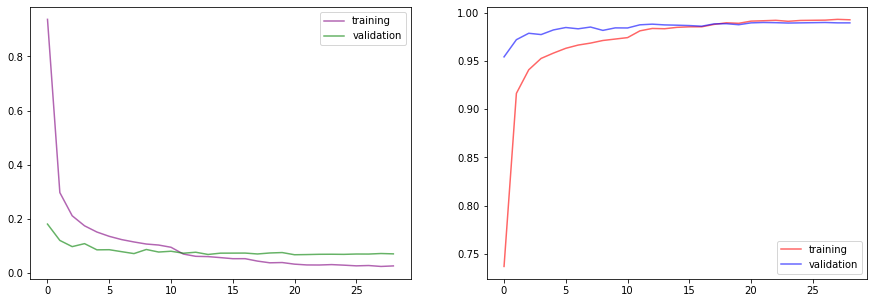

In [131]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))


sns.lineplot(x = list(range(len(katakana_training_loss))),
             y = katakana_training_loss, color = 'purple', alpha = 0.6, label='training', ax = ax1)
sns.lineplot(x = list(range(len(katakana_val_loss))),
             y = katakana_val_loss, color = 'green', alpha = 0.6, label = 'validation', ax = ax1)
sns.lineplot(x = list(range(len(katakana_training_loss))),
             y = katakana_training_accuracy, color = 'r', alpha = 0.6, label = 'training', ax = ax2)
sns.lineplot(x = list(range(len(katakana_val_loss))),
             y = katakana_val_accuracy, color = 'b', alpha = 0.6, label = 'validation', ax = ax2)
# plt.savefig('img/katakana_loss_acc.png')
ax1.legend();

#### Katakana Test Data Results

In [116]:
katakana_y_hat_test = np.argmax(katakana_model.predict(katakana_X_test), axis=-1)
katakana_test_restore = katakana_ohe.inverse_transform(katakana_y_test)
confusion_matrix(katakana_test_restore, katakana_y_hat_test)

array([[289,   0,   0, ...,   0,   0,   0],
       [  0, 264,   0, ...,   0,   0,   1],
       [  0,   0, 290, ...,   1,   0,   0],
       ...,
       [  0,   0,   1, ..., 278,   0,   0],
       [  0,   0,   0, ...,   0, 280,   0],
       [  0,   0,   0, ...,   0,   0, 259]], dtype=int64)

In [117]:
katakana_test_loss, katakana_test_acc = katakana_model.evaluate(katakana_X_test, katakana_y_test)

406/406 [==============================] - 9s 23ms/step - loss: 0.0661 - accuracy: 0.9891


In [119]:
print(f'We acheived a test accuracy of {round(katakana_test_acc, 4)}% on our Katakana dataset.')

We acheived a test accuracy of 0.9891% on our Katakana dataset.


## Conclusions & Next Steps